In [1]:
!python generate_data.py

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
from functools import reduce
from utils.models import strong_model_factory, weak_model_factory, no_rfx_model_factory
from utils.tools import load_obj, summarize_posterior, summarize_ppc

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext blackcellmagic


%load_ext autoreload
%autoreload 2

# Strong Priors

In [3]:
model_data = load_obj('data/bootstrap_data')

yobs = model_data['Yobs']
subject_ids = model_data['subject_ids']
y = model_data['y_est']
times = model_data['times']

with strong_model_factory(yobs, times, subject_ids, use_delay = True):

    prior_predictive = pm.sample_prior_predictive(1000)
    trace = pm.sample(draws = 1000, tune = 1000, chains = 4, random_seed = 19920908)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    strong_data = az.from_pymc3(prior=prior_predictive, trace=trace, posterior_predictive=posterior_predictive)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, delays, delay_kappa, delay_mu, s_ka, z_ka, alpha, s_ke, z_ke, log_ke, s_CL, z_CL, log_CL]
100%|██████████| 4000/4000 [00:06<00:00, 605.60it/s]


In [4]:
df = pd.DataFrame({'yobs':yobs,
                   'y':y,
                   'times':times,
                   'subject_ids':subject_ids})

predictions = summarize_posterior(strong_data, 'y_est', 'pred')
ppc = summarize_ppc(strong_data,'Yobs','ppc')

dfpred = df.join(predictions).join(ppc)

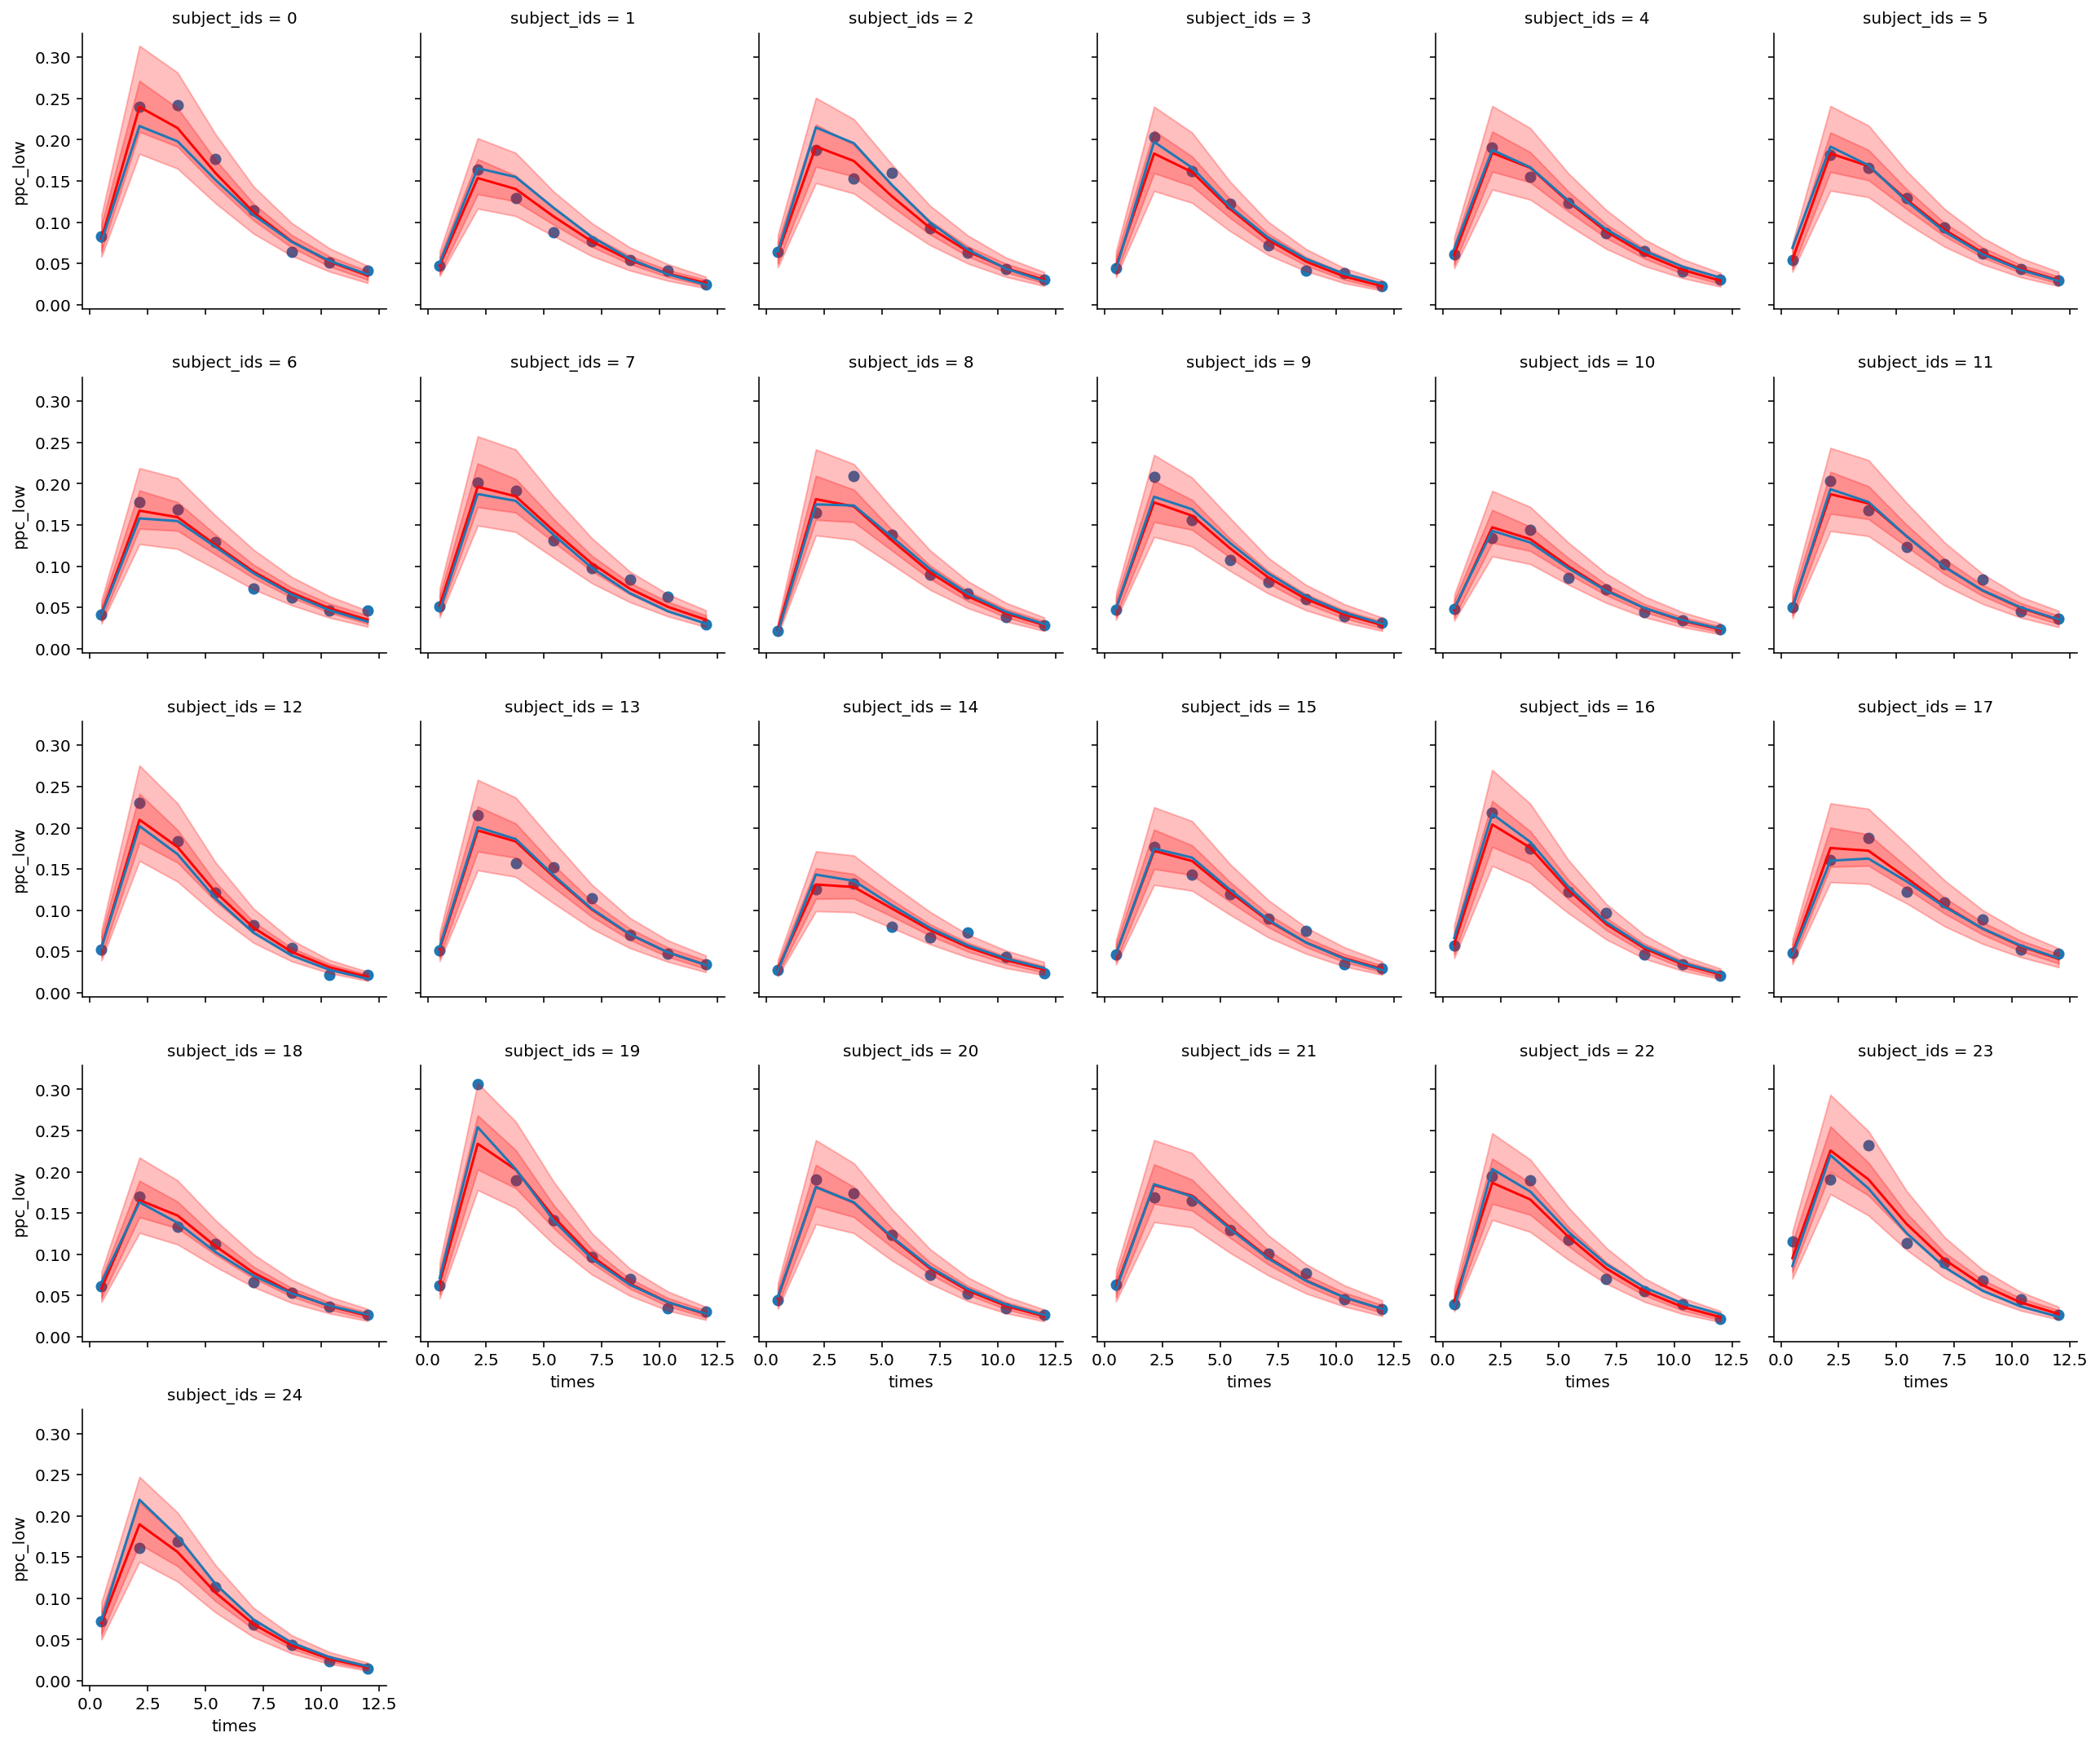

In [5]:
g = sns.FacetGrid(data = dfpred.query('subject_ids<=25'), col='subject_ids', col_wrap=6)

g.map(plt.scatter, 'times','yobs', color = 'C0')
g.map(plt.plot, 'times','pred_pred', color = 'red')
g.map(plt.plot, 'times','y', color = 'C0')
g.map(plt.fill_between,'times','pred_low','pred_high',alpha = 0.25, color = 'red')
g.map(plt.fill_between,'times','ppc_low','ppc_high',alpha = 0.25, color = 'red')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c330e6850>],
      dtype=object)

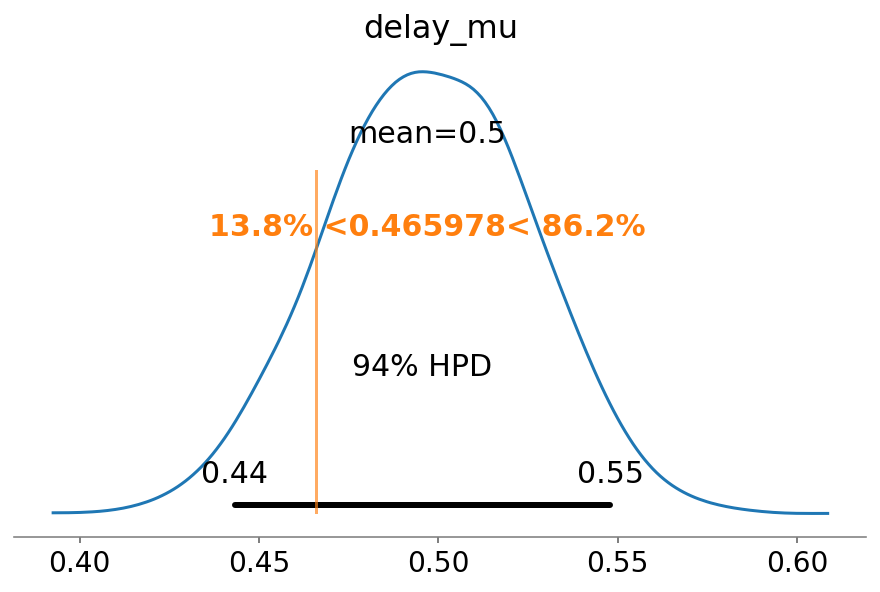

In [6]:
az.plot_posterior(strong_data, var_names=['delay_mu'], ref_val=float(model_data['delay_mu']))

# Weak Priors

In [7]:
with weak_model_factory(yobs, times, subject_ids, use_delay = True):
    prior_predictive = pm.sample_prior_predictive(1000)
    trace = pm.sample(draws = 1000, tune = 1000, chains = 4, random_seed = 19920908)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    weak_data = az.from_pymc3(prior=prior_predictive, trace=trace, posterior_predictive=posterior_predictive)
    
predictions = summarize_posterior(weak_data, 'y_est', 'pred')
ppc = summarize_ppc(weak_data,'Yobs','ppc')

dfpred = df.join(predictions).join(ppc)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, delays, delay_kappa, delay_mu, s_ka, z_ka, alpha, s_ke, z_ke, log_ke, s_CL, z_CL, log_CL]
Sampling 4 chains, 115 divergences: 100%|██████████| 8000/8000 [00:56<00:00, 142.53draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5663857496924161, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.623943978840426, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is sma

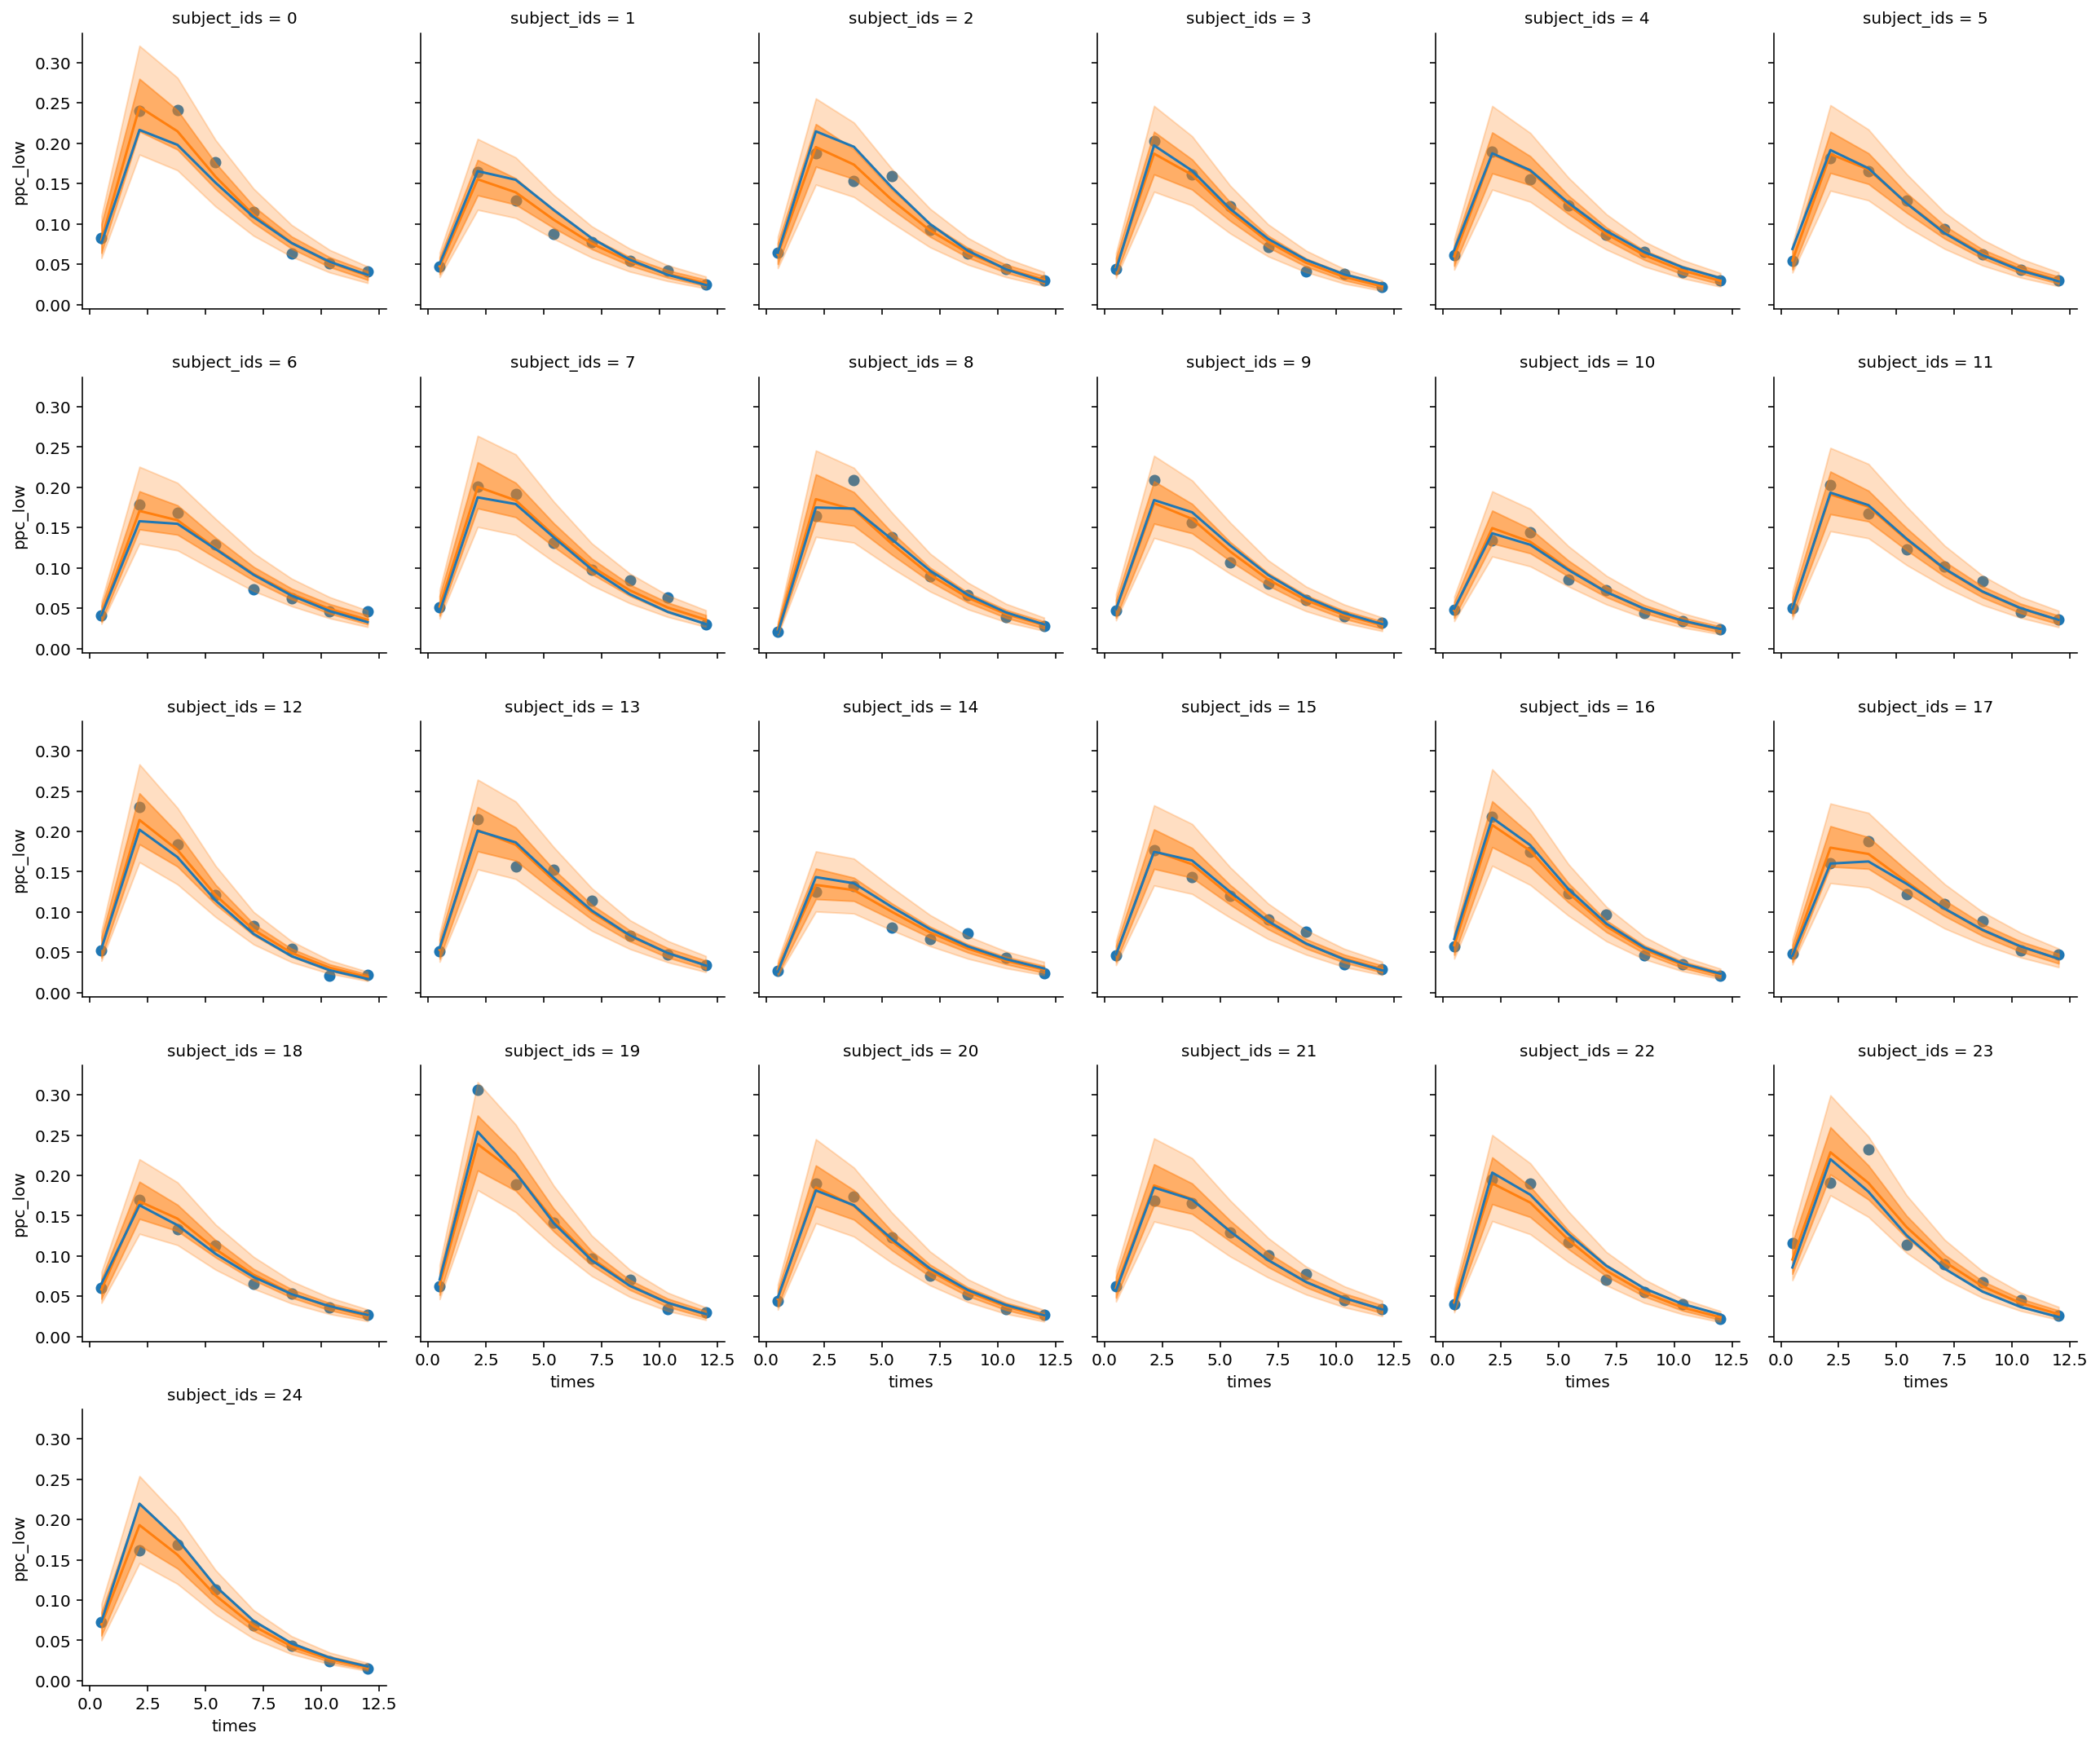

In [8]:
g = sns.FacetGrid(data = dfpred.query('subject_ids<=25'), col='subject_ids', col_wrap=6)

g.map(plt.scatter, 'times','yobs', color = 'C0')
g.map(plt.plot, 'times','pred_pred', color = 'C1')
g.map(plt.plot, 'times','y', color = 'C0')
g.map(plt.fill_between,'times','pred_low','pred_high',alpha = 0.5, color = 'C1')
g.map(plt.fill_between,'times','ppc_low','ppc_high',alpha = 0.25, color = 'C1')

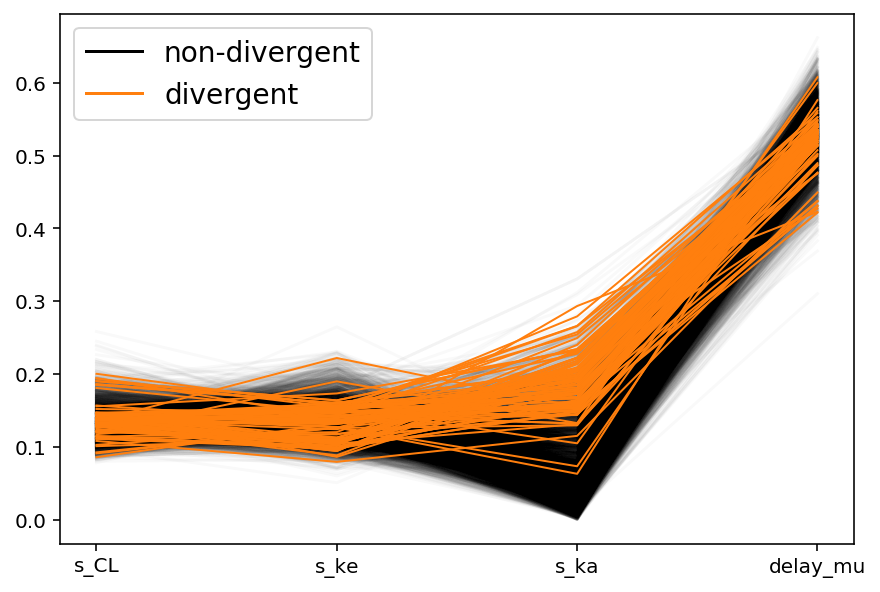

In [9]:
az.plot_parallel(weak_data, var_names=['s_CL','s_ke','s_ka', 'delay_mu'])

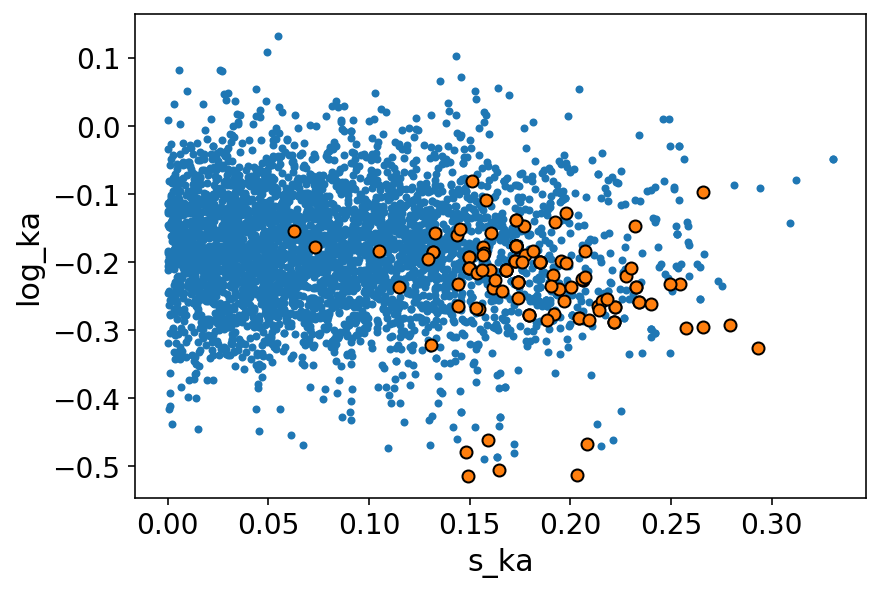

In [10]:
az.plot_pair(weak_data, var_names=['s_ka', 'log_ka'], divergences = True)

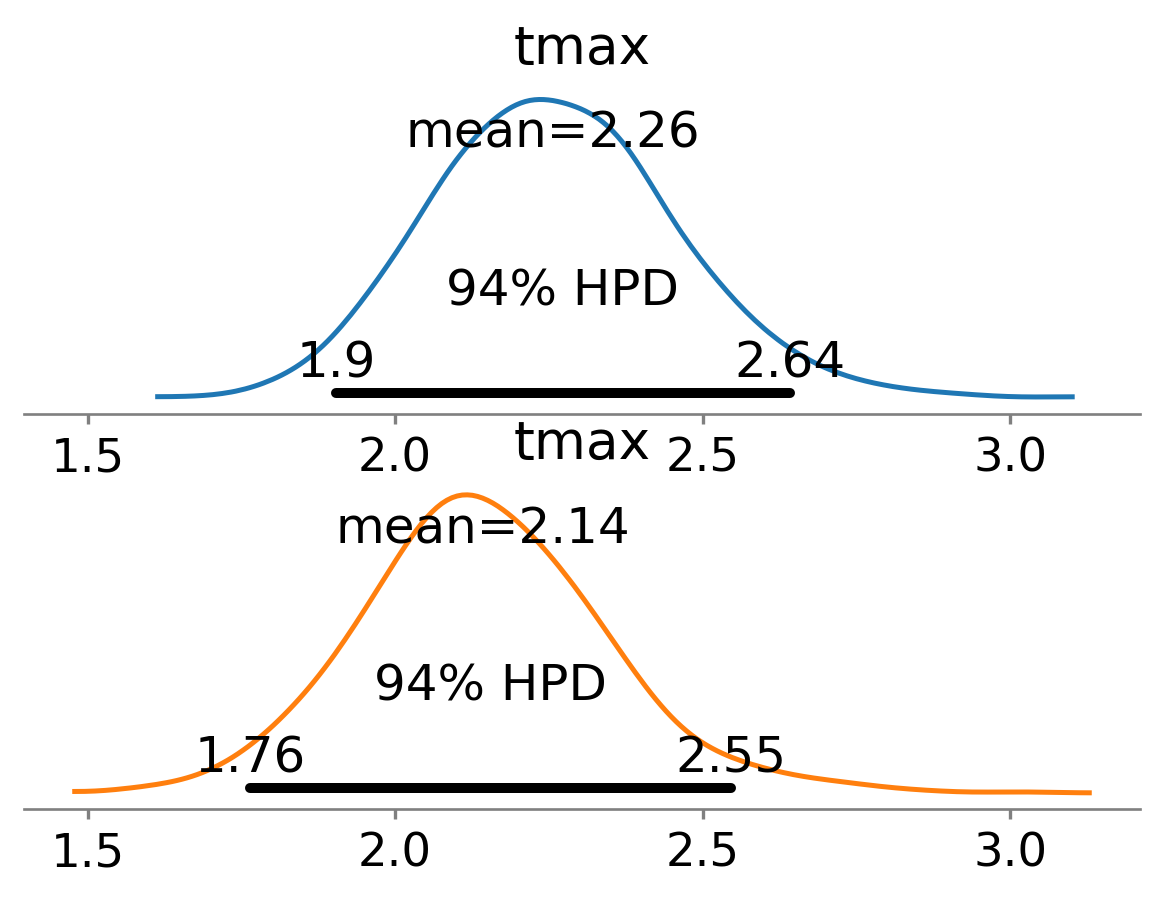

In [27]:
fig, ax = plt.subplots(dpi=120, nrows = 2, sharex = True)
az.plot_posterior(data=strong_data, var_names=['tmax'], round_to=3, ax = ax[0])
az.plot_posterior(data=weak_data, var_names=['tmax'], round_to=3, ax = ax[1], color = 'C1')

# No random effect in $k_a$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, delays, delay_kappa, delay_mu, alpha, s_ke, z_ke, log_ke, s_CL, z_CL, log_CL]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:45<00:00, 174.54draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 4000/4000 [00:05<00:00, 673.52it/s]


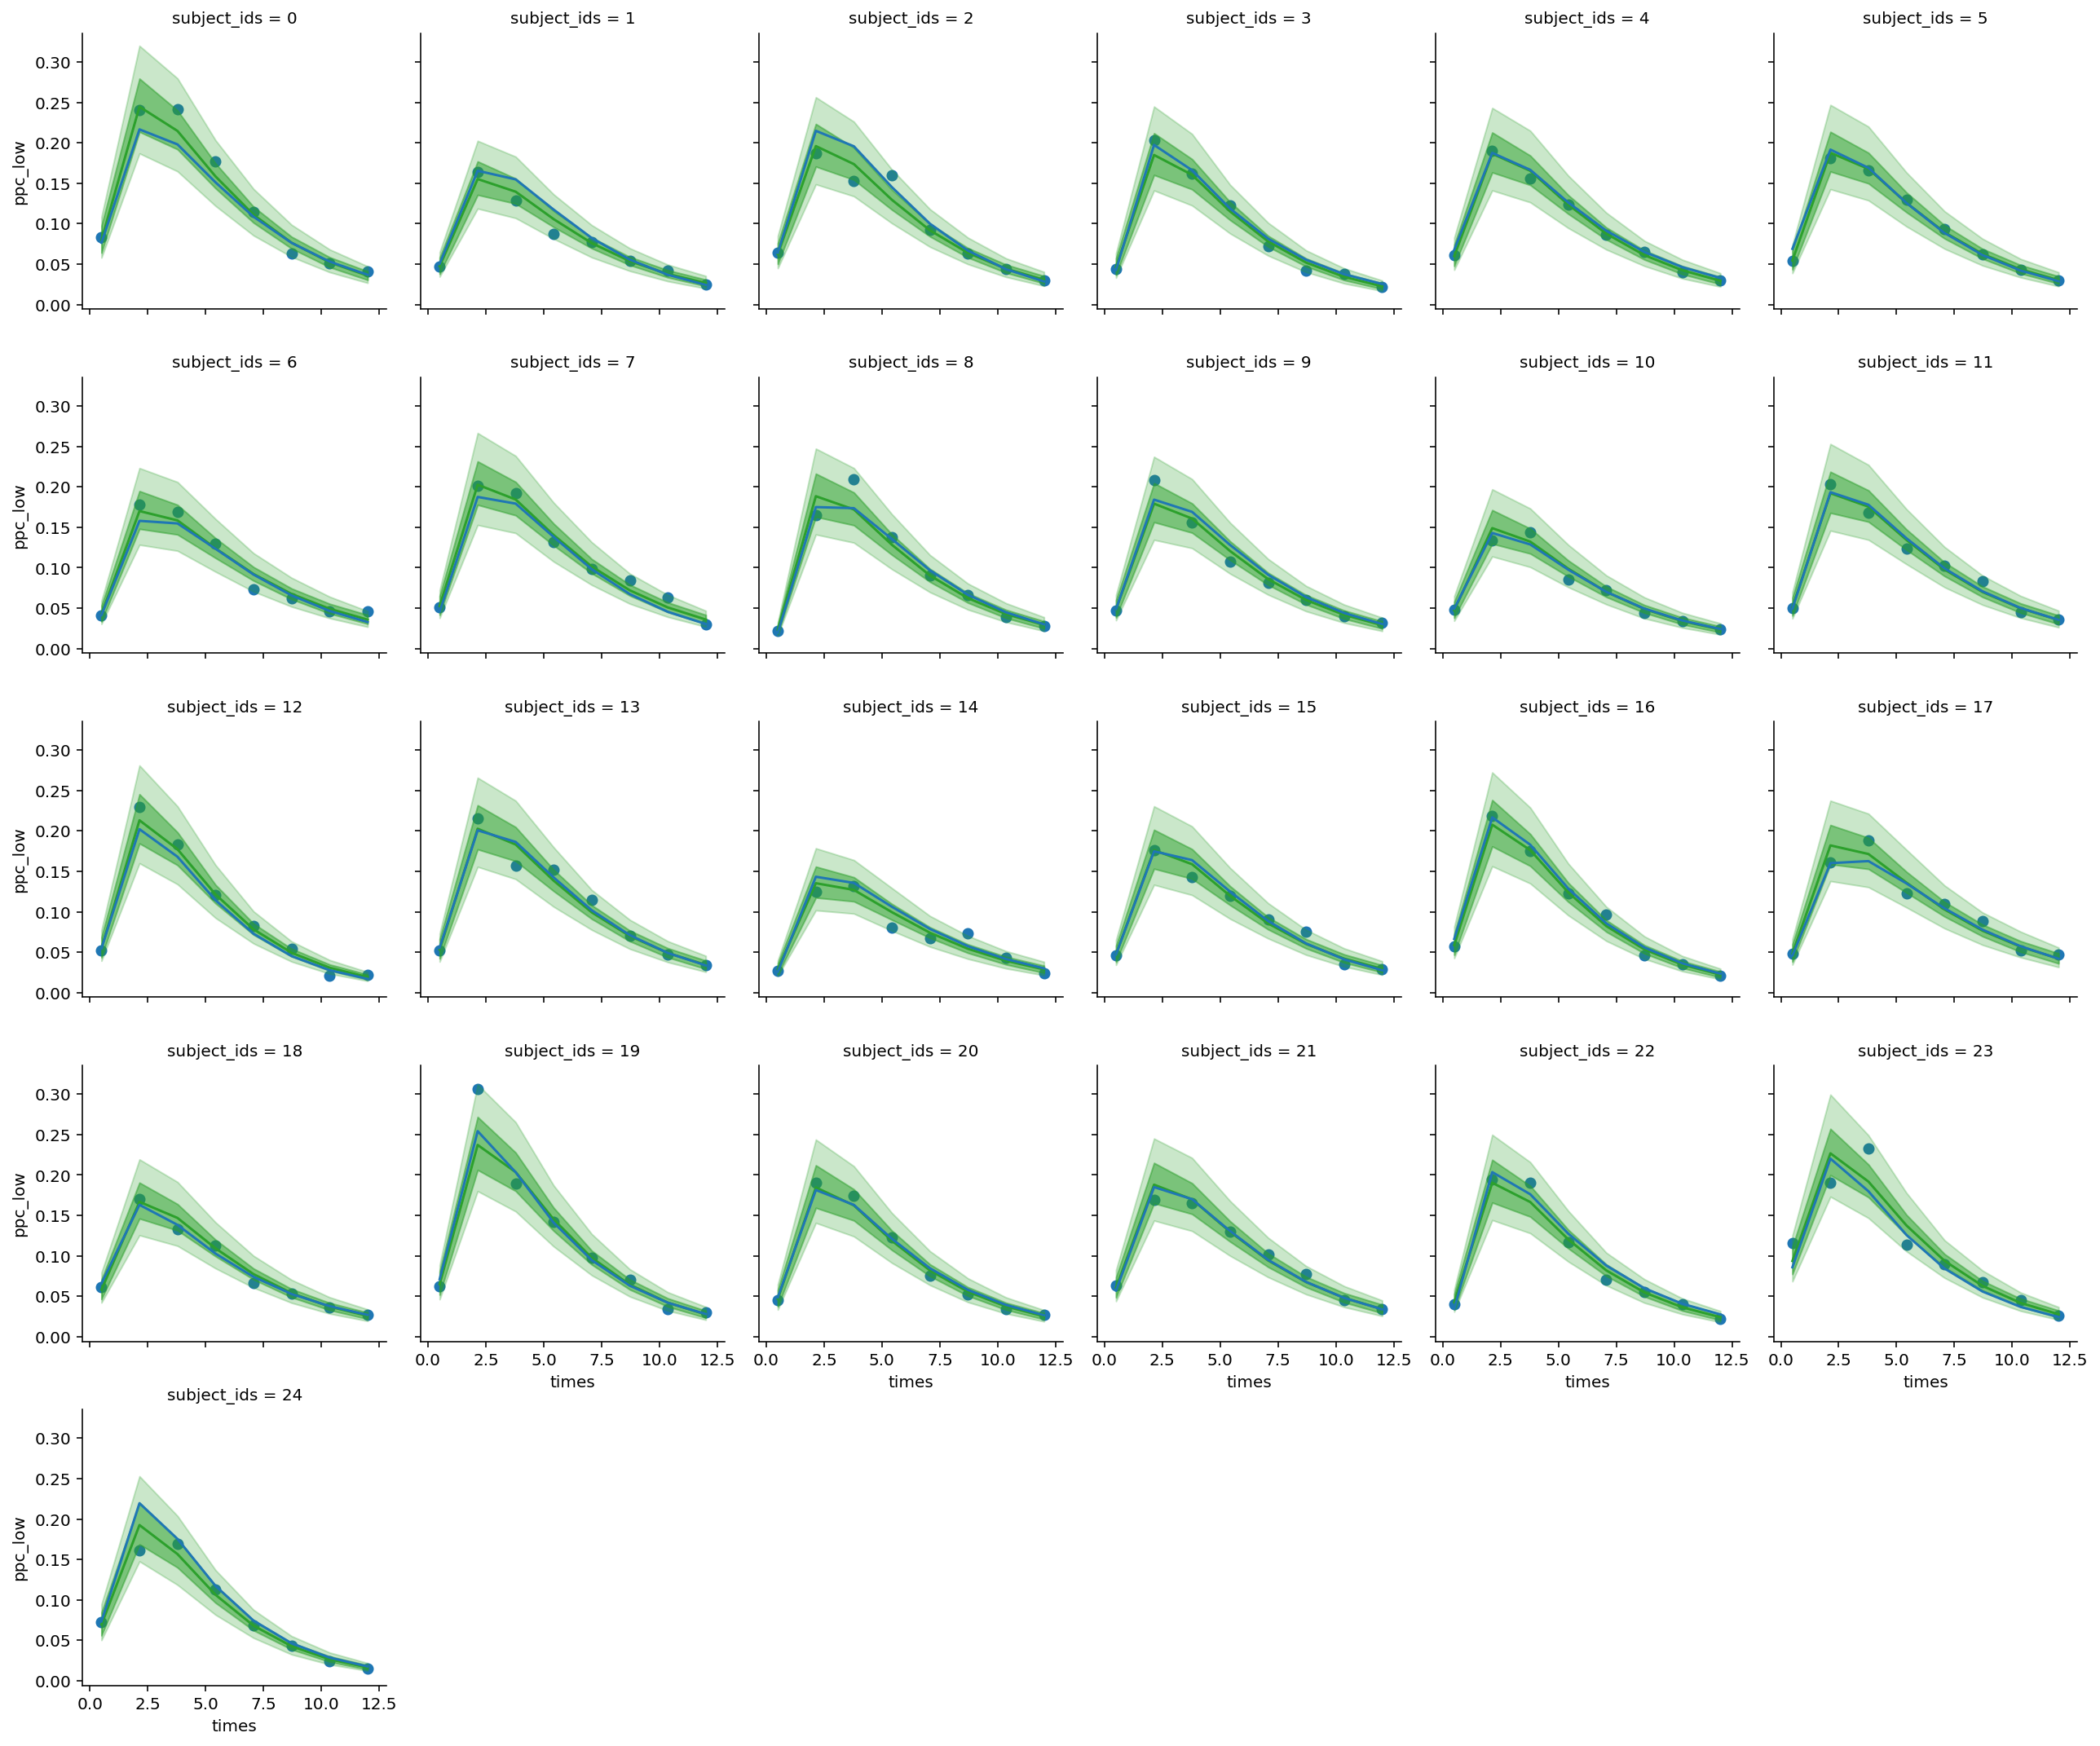

In [12]:
import theano.tensor as tt

with no_rfx_model_factory(yobs, times, subject_ids, use_delay = True):
    prior_predictive = pm.sample_prior_predictive(1000)
    trace = pm.sample(draws = 1000, tune = 1000, chains = 4, random_seed = 19920908)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    rfx_data = az.from_pymc3(prior=prior_predictive, trace=trace, posterior_predictive=posterior_predictive)
    
predictions = summarize_posterior(rfx_data, 'y_est', 'pred')
ppc = summarize_ppc(rfx_data,'Yobs','ppc')

dfpred = df.join(predictions).join(ppc)

g = sns.FacetGrid(data = dfpred.query('subject_ids<=25'), col='subject_ids', col_wrap=6)

g.map(plt.scatter, 'times','yobs', color = 'C0')
g.map(plt.plot, 'times','pred_pred', color = 'C2')
g.map(plt.plot, 'times','y', color = 'C0')
g.map(plt.fill_between,'times','pred_low','pred_high',alpha = 0.5, color = 'C2')
g.map(plt.fill_between,'times','ppc_low','ppc_high',alpha = 0.25, color = 'C2')

(<Figure size 432x453.6 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c347cb5d0>],
       dtype=object))

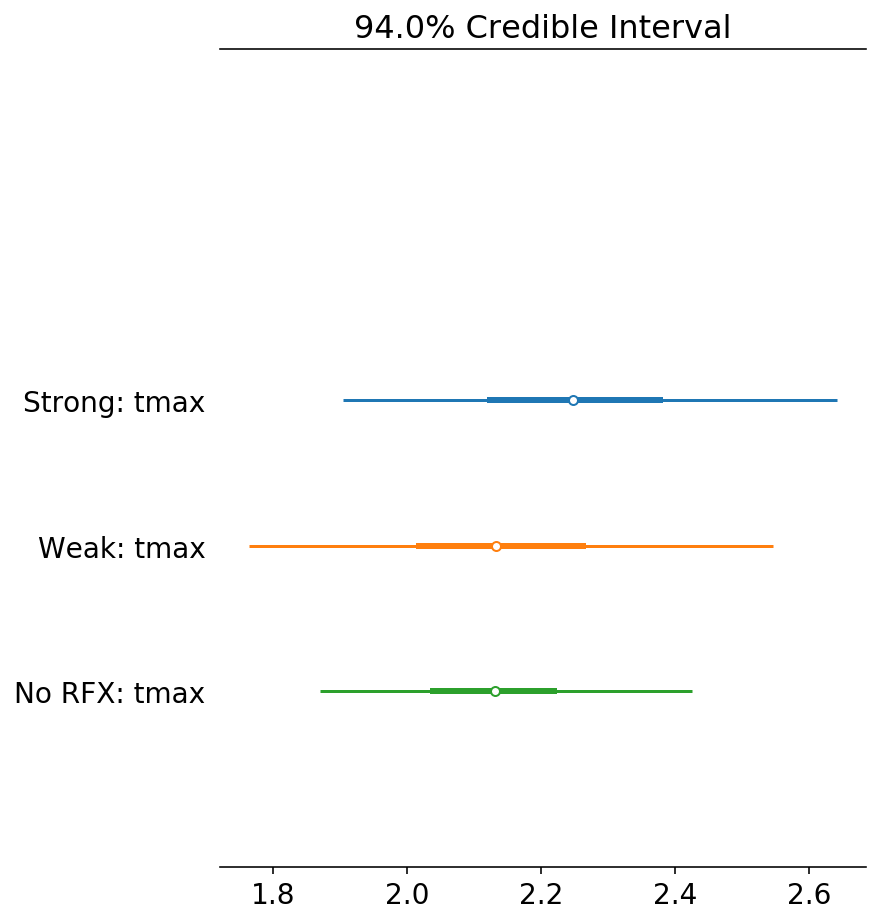

In [13]:
az.plot_forest(data = [strong_data, weak_data, rfx_data], model_names=['Strong','Weak','No RFX'], var_names=['tmax'], combined=True)

# Summarize Posteriors With Mean and Credible Interval

In [14]:
funcs = {'mean':np.mean, 'hpd_2.5%':lambda x: np.percentile(x, 2.5), 'hpd_97.5%':lambda x: np.percentile(x, 97.5)}
num_funcs = len(funcs.keys())

strong_summary = az.summary(strong_data, stat_funcs=funcs, extend = False)
strong_summary['model'] = 'strong'


weak_summary = az.summary(weak_data, stat_funcs=funcs, extend = False)
weak_summary['model'] = 'weak'

rfx_summary = az.summary(rfx_data, stat_funcs=funcs, extend = False)
rfx_summary['model'] = 'no_rfx'


model_summaries = pd.concat((strong_summary, weak_summary, rfx_summary))





In [15]:
model_summaries


mean  hpd_2.5%  hpd_97.5%   model
log_CL      1.315     1.266      1.364  strong
z_CL[0]    -2.009    -2.813     -1.195  strong
z_CL[1]     1.262     0.487      2.052  strong
z_CL[2]    -0.371    -1.162      0.386  strong
z_CL[3]     0.805     0.008      1.603  strong
...           ...       ...        ...     ...
y_est[196]  0.068     0.062      0.074  no_rfx
y_est[197]  0.043     0.039      0.047  no_rfx
y_est[198]  0.026     0.023      0.030  no_rfx
y_est[199]  0.016     0.014      0.019  no_rfx
sigma       0.122     0.108      0.138  no_rfx

[1114 rows x 4 columns]

In [16]:
variables={}
for var in model_data:
    
    if model_data[var].size>1:
        data= model_data[var]
        for i in range(data.size):
            variables[f'{var}[{i}]'] = data[i]
    else:
        variables[var] = float(model_data[var])
    

In [17]:
g = pd.DataFrame(variables.values(), columns=['mean'], index = variables.keys())
g['model'] = 'truth'

s = pd.concat((g, model_summaries))

s

/Users/demetri/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


hpd_2.5%  hpd_97.5%      mean   model
alpha            NaN        NaN  0.315111   truth
delays[0]        NaN        NaN  0.345236   truth
delays[1]        NaN        NaN  0.423473   truth
delays[2]        NaN        NaN  0.462463   truth
delays[3]        NaN        NaN  0.696147   truth
...              ...        ...       ...     ...
y_est[196]     0.062      0.074  0.068000  no_rfx
y_est[197]     0.039      0.047  0.043000  no_rfx
y_est[198]     0.023      0.030  0.026000  no_rfx
y_est[199]     0.014      0.019  0.016000  no_rfx
sigma          0.108      0.138  0.122000  no_rfx

[2134 rows x 4 columns]

Text(0, 0.5, 'No Rfx Model Predictions')

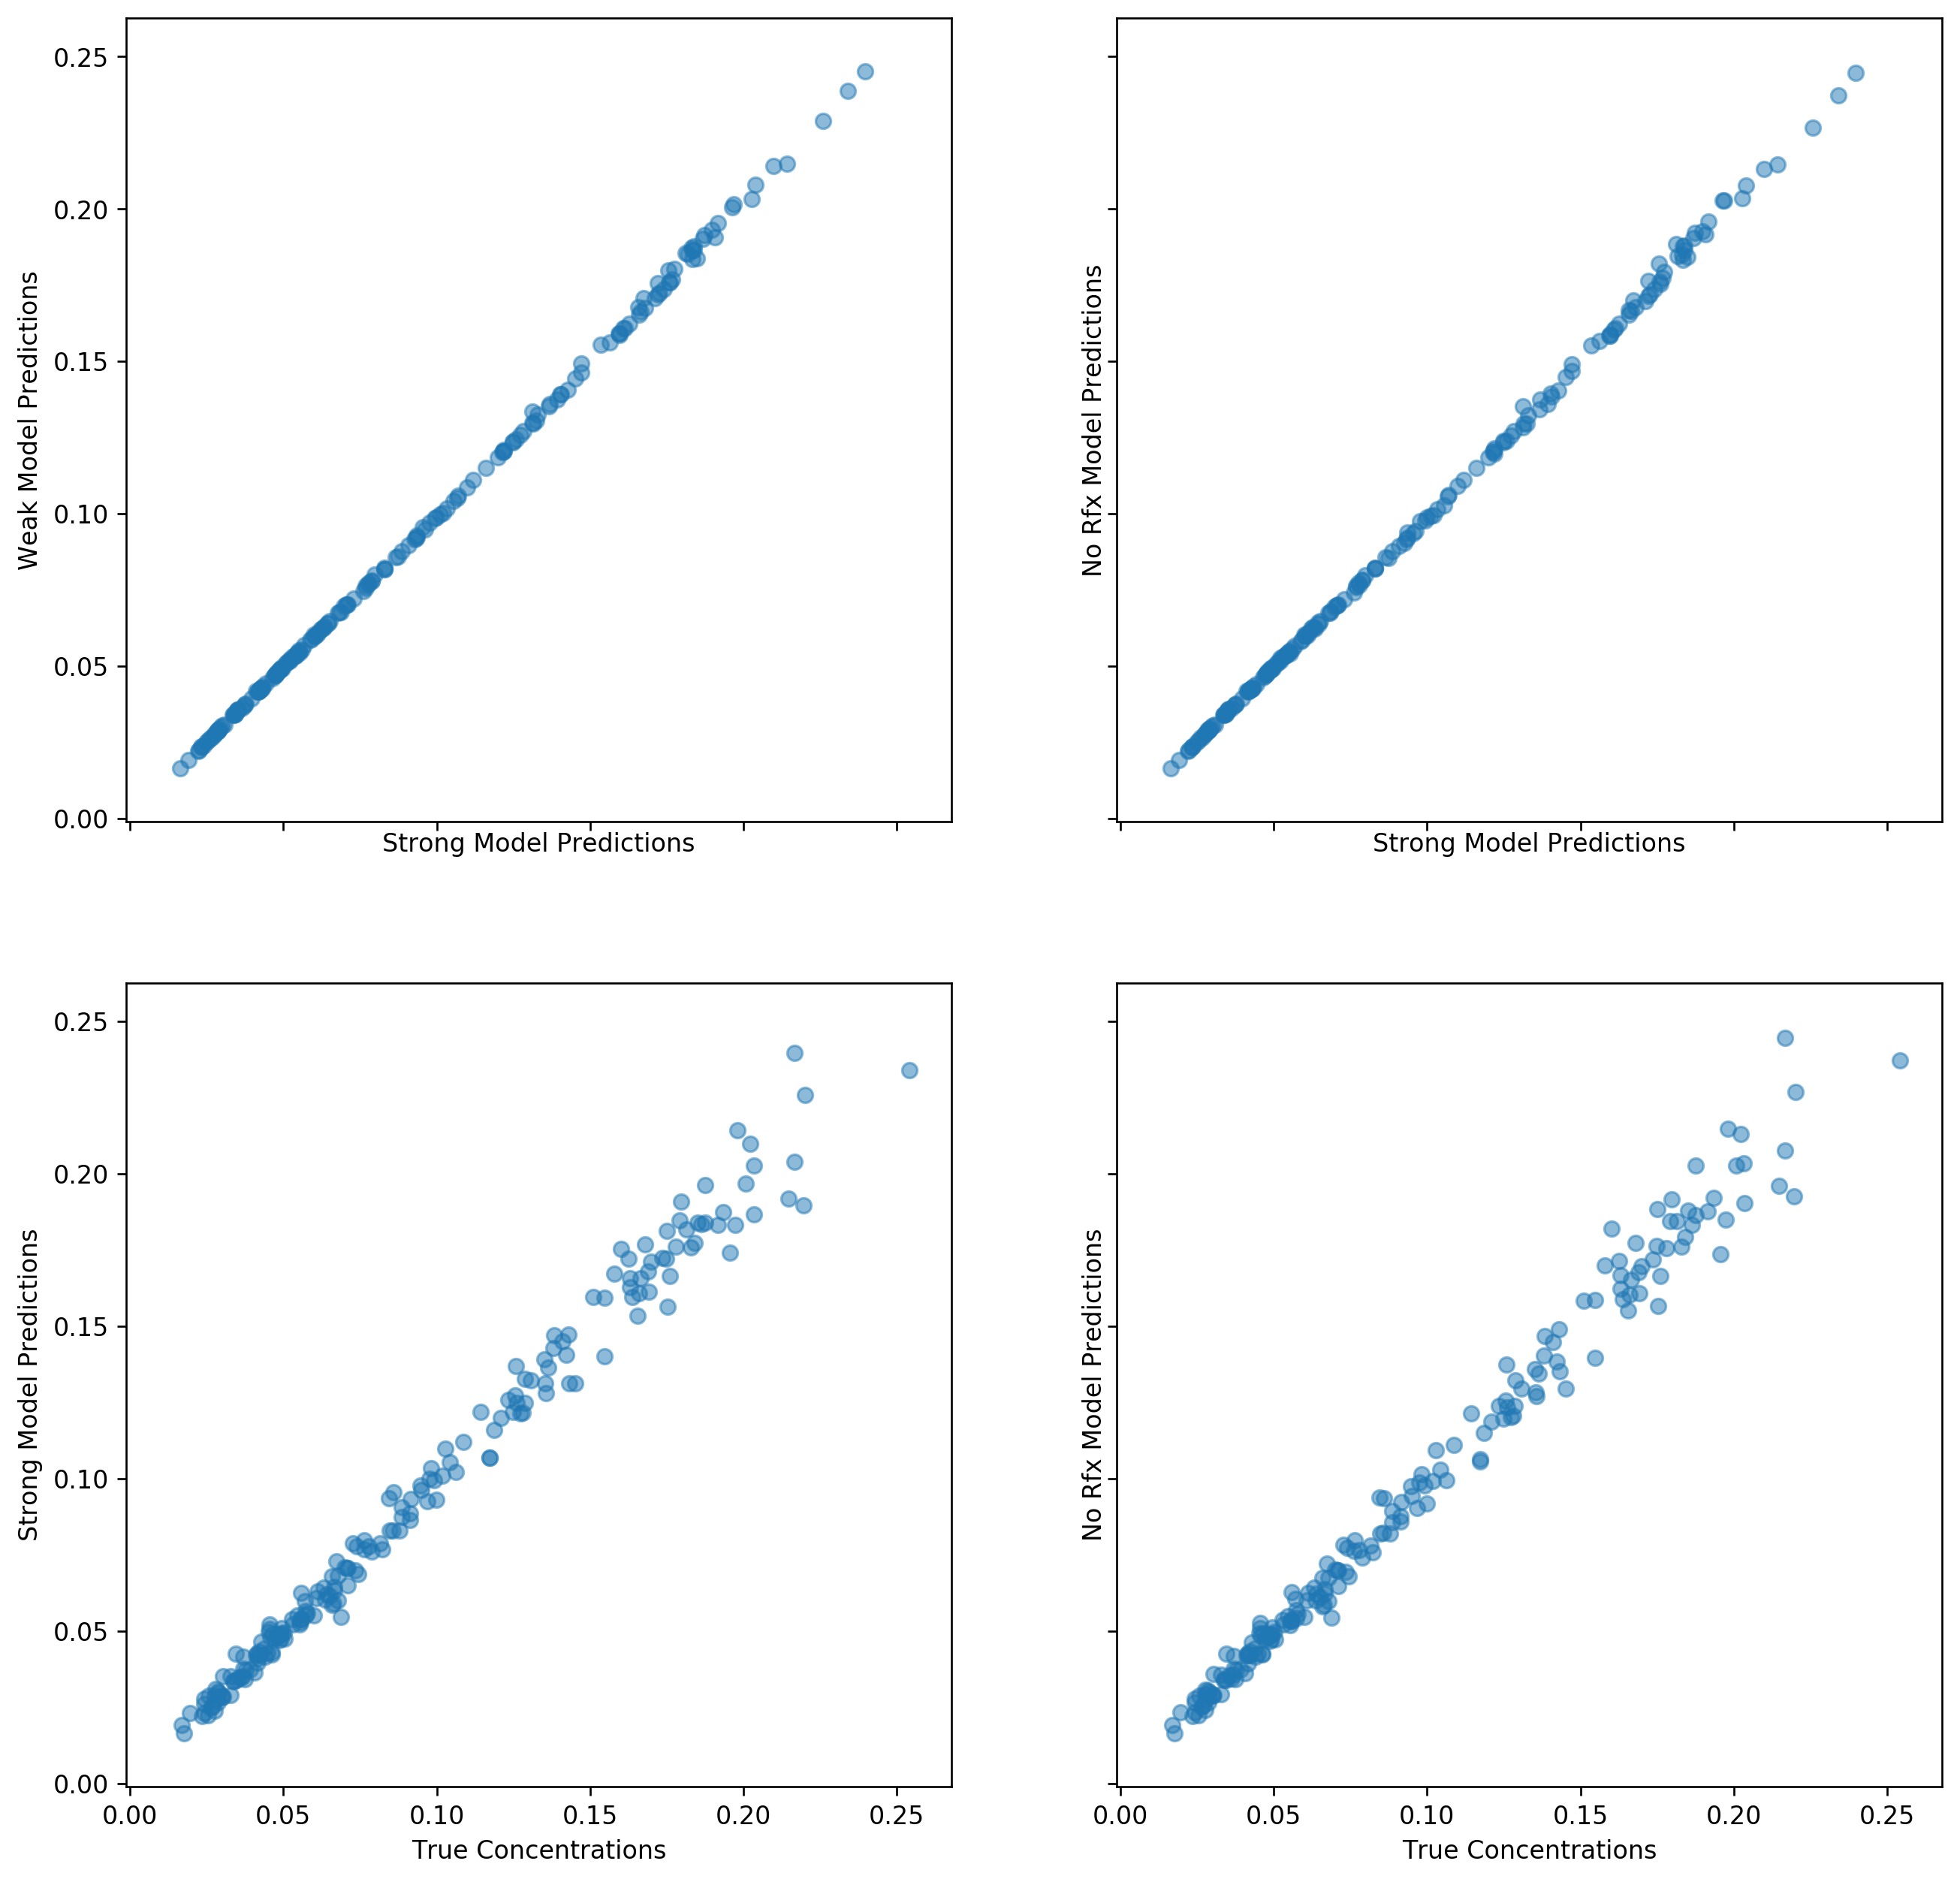

In [18]:
predictions = summarize_posterior(strong_data, 'y_est', 'pred')
ppc = summarize_ppc(strong_data,'Yobs','ppc')

strong_sum = df.join(predictions).join(ppc)

predictions = summarize_posterior(weak_data, 'y_est', 'pred')
ppc = summarize_ppc(weak_data,'Yobs','ppc')

weak_sum = df.join(predictions).join(ppc)

predictions = summarize_posterior(rfx_data, 'y_est', 'pred')
ppc = summarize_ppc(rfx_data,'Yobs','ppc')

rfx_sum = df.join(predictions).join(ppc)


fig, ax = plt.subplots(dpi=120, ncols=2, nrows=2, figsize = (13,13), sharex = True, sharey=True)

ax = ax.ravel()

ax[0].scatter(strong_sum.pred_pred, weak_sum.pred_pred, alpha = 0.5)
ax[0].set_xlabel('Strong Model Predictions')
ax[0].set_ylabel('Weak Model Predictions')


ax[1].scatter(strong_sum.pred_pred, rfx_sum.pred_pred, alpha = 0.5)
ax[1].set_xlabel('Strong Model Predictions')
ax[1].set_ylabel('No Rfx Model Predictions')


ax[2].scatter(strong_sum.y, strong_sum.pred_pred, alpha = 0.5)
ax[2].set_xlabel('True Concentrations')
ax[2].set_ylabel('Strong Model Predictions')


ax[3].scatter(rfx_sum.y, rfx_sum.pred_pred, alpha = 0.5)
ax[3].set_xlabel('True Concentrations')
ax[3].set_ylabel('No Rfx Model Predictions')



# Estimate $t_{max}$ From 3 Models

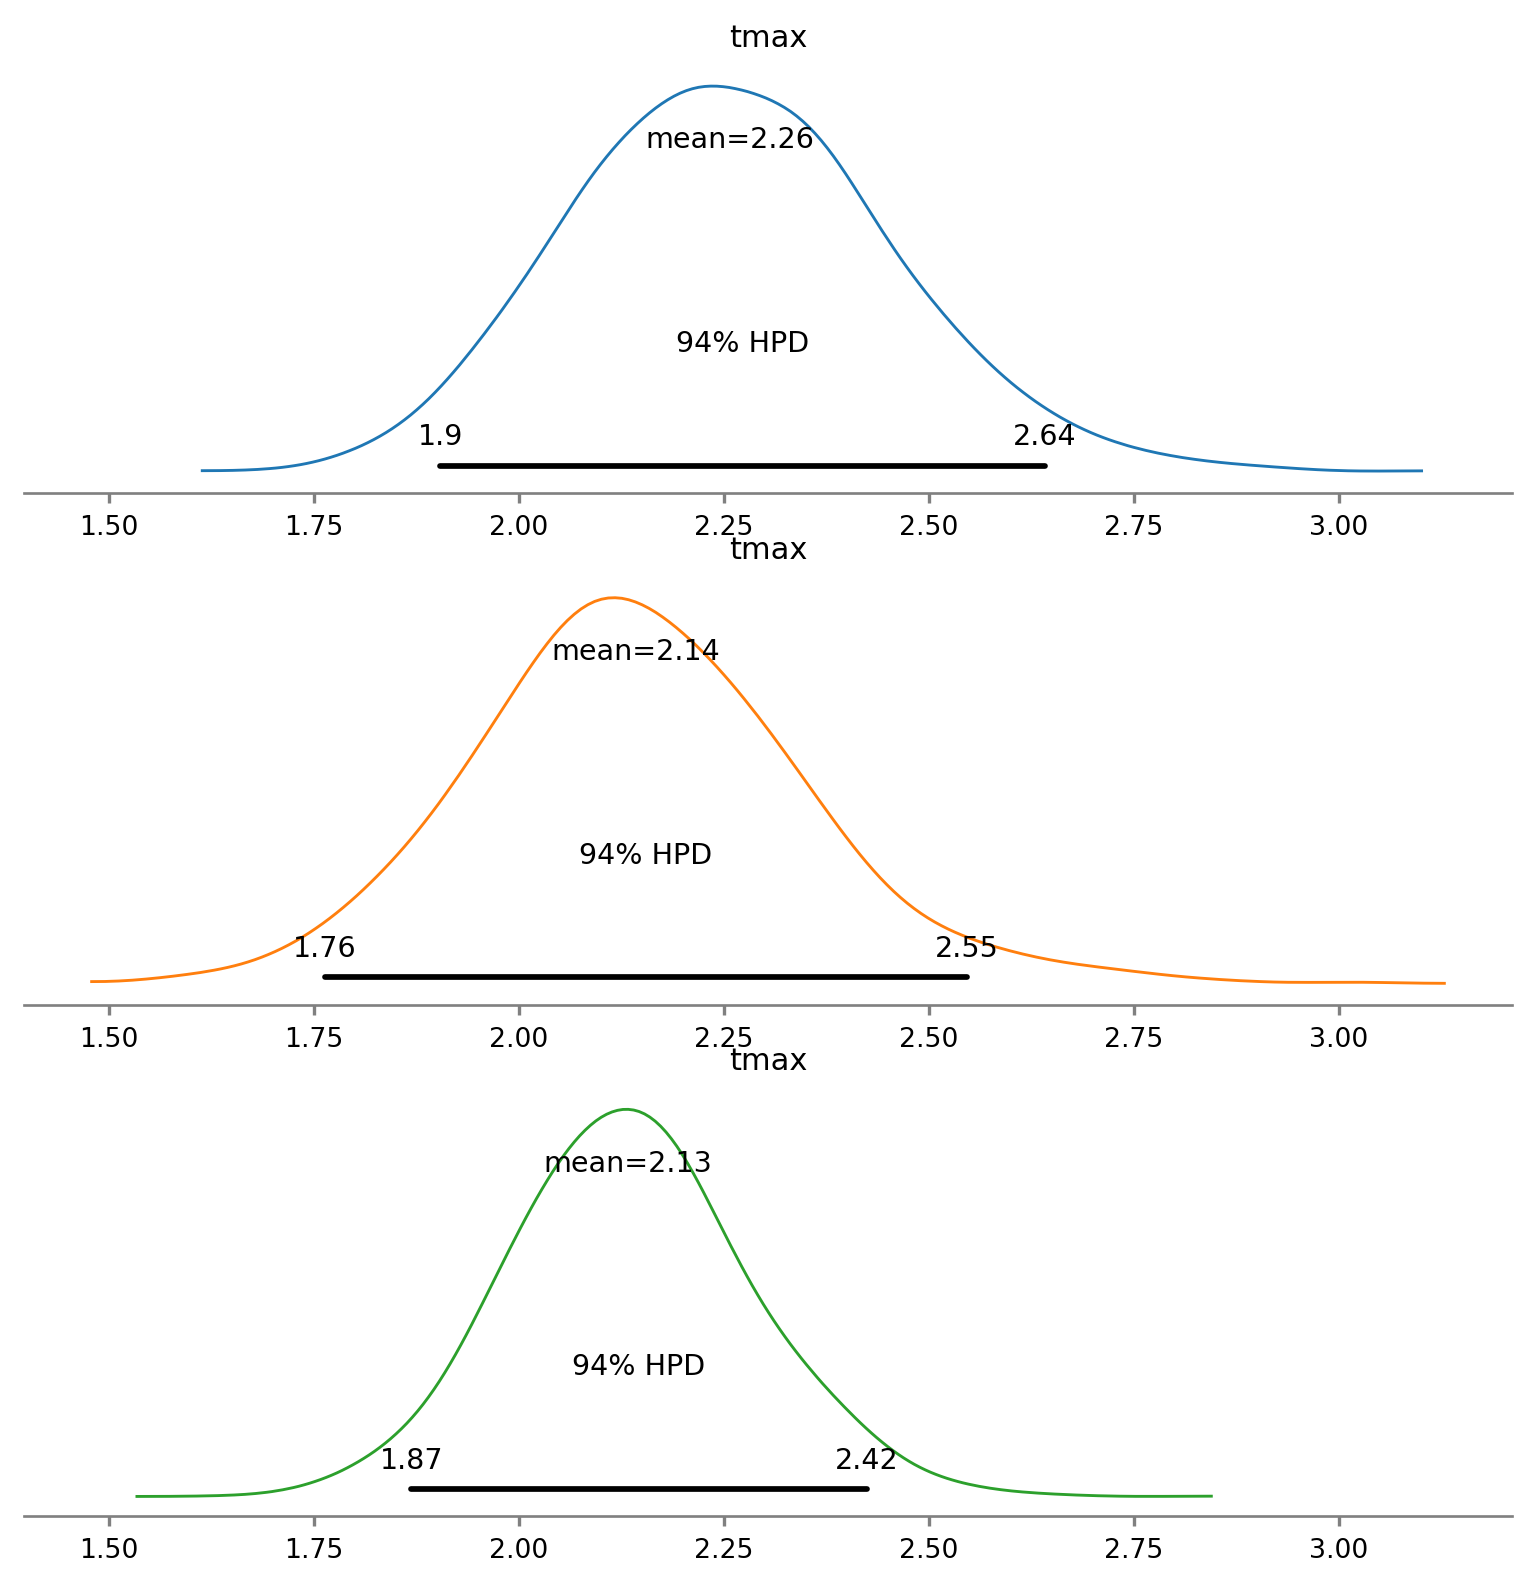

In [36]:
fig, ax = plt.subplots(dpi=120, nrows = 3, sharex = True, figsize = (8,8))

models = [strong_data, weak_data, rfx_data]

colors = ['C0','C1','C2']

for a,m,c in zip(ax, models, colors):
    az.plot_posterior(data=m, var_names=['tmax'], round_to=3, ax = a, color=c, textsize=8)